In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from src.io_data_model import (
    load_model,
    load_and_dateindex_data,
    save_model,
)

from src.transformation import (
    clean_delivery_data,
    resample_data,
    smooth_series,
)

from src.anomaly import (
    detect_anomalies,
    calculate_anomaly_percentage,
)

from src.plotting import (
    plot_anomalies,
    plot_anomalies_and_rolling,
    plot_forecast,
    plot_train_splits,
    plot_test_splits,
    plot_eighty_twenty_series,
)

from src.time_series import (
    find_best_arima_order,
    find_best_sarima_model,
    evaluate_models,
    rank_models,
    fit_sarima_model,
    fit_exp_smooth_model,
    fit_prophet_model,
    display_metrics,
)

In [ ]:
from sunflower_delivery_parms import config

CROP = config["CROP"]
DATA_FILE = config["DATA_FILE"]
DATA_FILE_PATH = config["DATA_FILE_PATH"]
MODEL_FILE = config["MODEL_FILE"]
MODEL_PARMS = config["MODEL_PARMS"]
MODEL_PATH = config["MODEL_PATH"]
PERIOD = config["PERIOD"]
ROLLING_AVERAGE_WINDOW = config["ROLLING_AVERAGE_WINDOW"]
SMOOTHED_TARGET_VARIABLE = config["SMOOTHED_TARGET_VARIABLE"]
TARGET_VARIABLE = config["TARGET_VARIABLE"]
TRAIN_SPLIT = config["TRAIN_SPLIT"]

The overall code in this Jupyter Notebook is designed to analyze and forecast crop deliveries using various time series models. The workflow includes data loading, preprocessing, exploratory data analysis, model fitting, evaluation, and forecasting. The models used include SARIMA, Exponential Smoothing, and Prophet. The notebook also includes visualizations to help understand the data and the model outputs.

In [4]:
# loaded_model = load_model(MODEL_PATH, MODEL_FILE)
# print(loaded_model.summary())

In [5]:
indexed_df = load_and_dateindex_data(DATA_FILE_PATH, DATA_FILE)
cleaned_df = clean_delivery_data(indexed_df, TARGET_VARIABLE, CROP)
cleaned_df.head()

,Crop Delivery (Tonnes)
Date,
2018-01-03,1
2018-01-10,3
2018-01-17,82
2018-01-24,2731
2018-01-31,25


In [6]:
# Get summary statistics
cleaned_df.describe().map(lambda x: f"{x:,.0f}")

,Crop Delivery (Tonnes)
count,364
mean,"14,299"
std,"26,300"
min,0
25%,201
50%,"1,056"
75%,"17,480"
max,"231,151"


<Axes: xlabel='Date', ylabel='Crop Delivery (Tonnes)'>

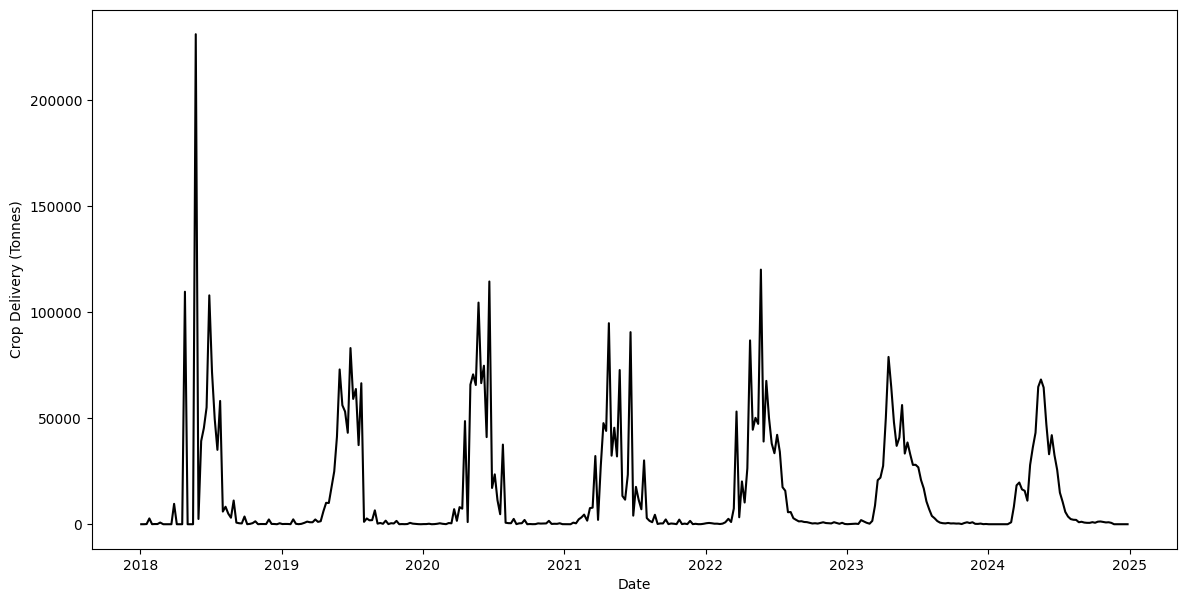

In [7]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=cleaned_df, x=cleaned_df.index, y=TARGET_VARIABLE, color="black")

In [8]:
outlier_df, anomalies = detect_anomalies(cleaned_df, TARGET_VARIABLE, 0.05)
anomaly_df = calculate_anomaly_percentage(outlier_df)
anomaly_df

,Anomaly,Percentage
0,Not Anomaly,94.78022
1,Anomaly,5.21978


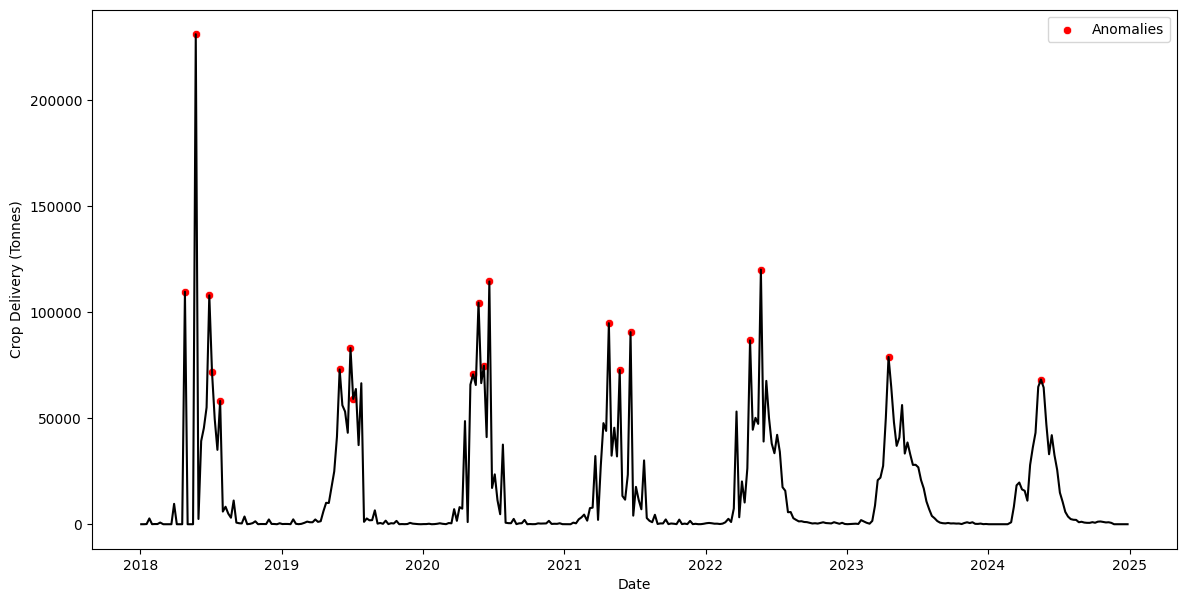

In [9]:
plot_anomalies(outlier_df, anomalies, TARGET_VARIABLE)

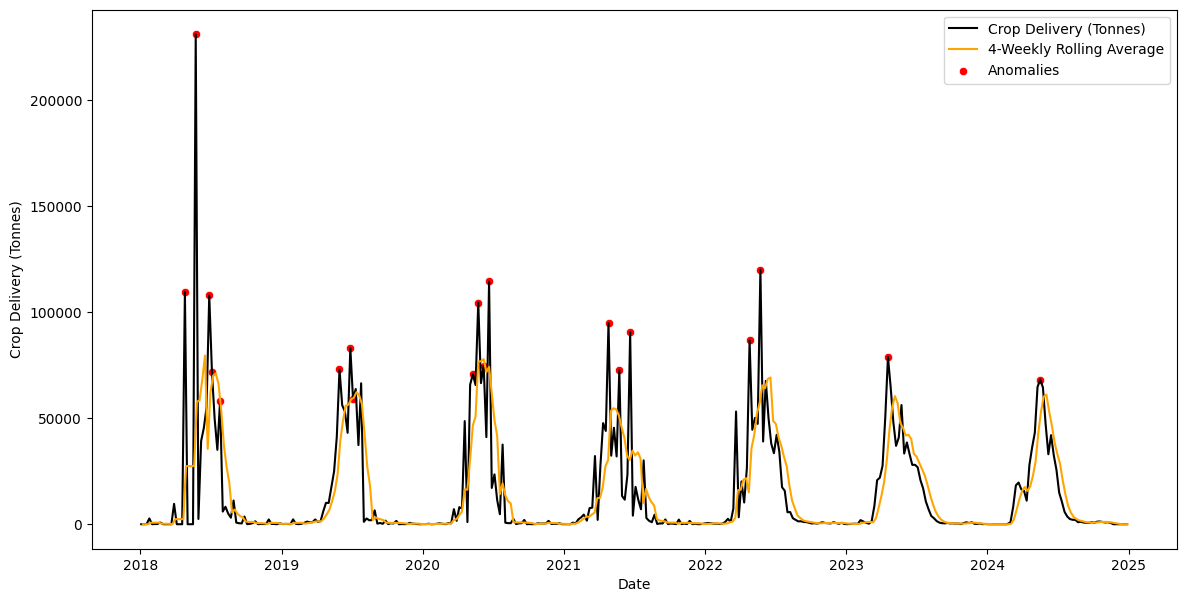

In [10]:
resampled_df = resample_data(outlier_df, TARGET_VARIABLE)
smoothed_series = smooth_series(
    resampled_df, TARGET_VARIABLE, ROLLING_AVERAGE_WINDOW, SMOOTHED_TARGET_VARIABLE
)

# Call the function
plot_anomalies_and_rolling(
    outlier_df, smoothed_series, anomalies, TARGET_VARIABLE, SMOOTHED_TARGET_VARIABLE
)

11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing


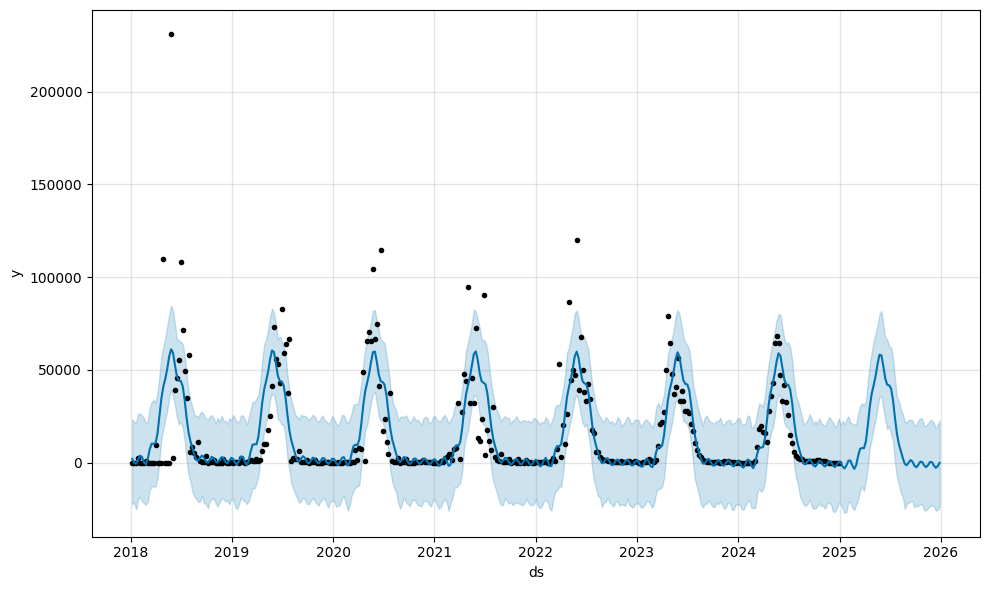

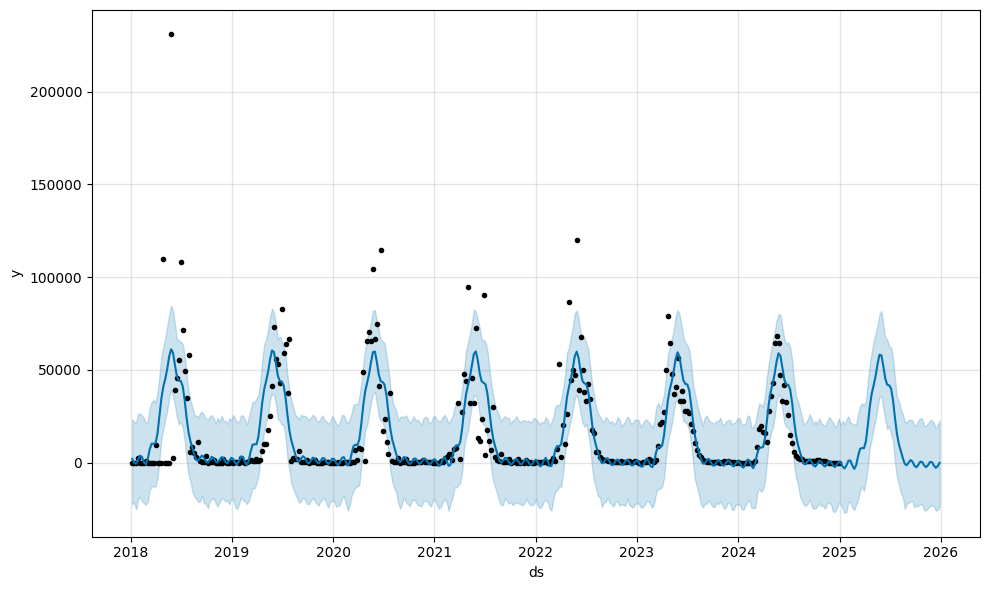

In [11]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = resampled_df.reset_index().rename(columns={"Date": "ds", TARGET_VARIABLE: "y"})
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

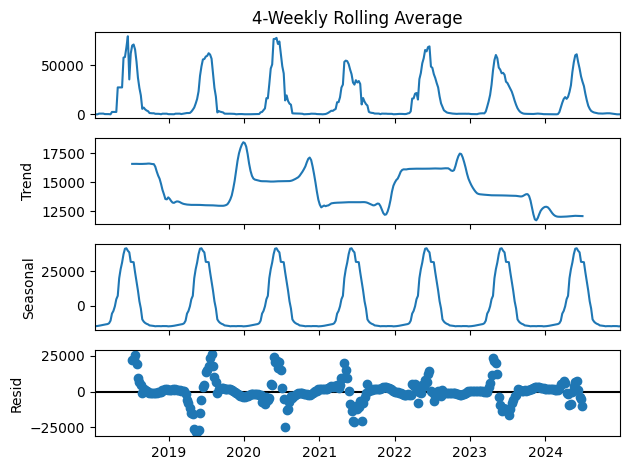

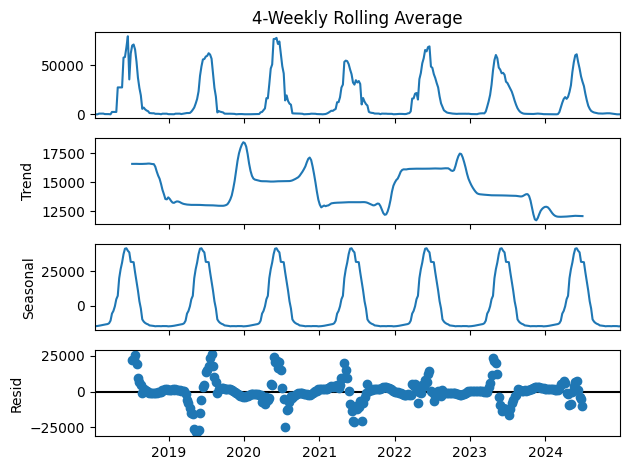

In [12]:
# Decompose the time series using the additive method
decomposition = seasonal_decompose(x=smoothed_series, model="additive", period=PERIOD)
# View the decomposed components
decomposition.plot()

In [13]:
# Perform the ADF test on the time series
result = adfuller(smoothed_series)

# Print the ADF test statistic, the p-value, and the critical values
print("ADF test statistic:", result[0])
print("p-value:", result[1])
print("Critical values:")
for key, value in result[4].items():
    print(key, value)

ADF test statistic: -5.427903064270908
p-value: 2.9588649757354925e-06
Critical values:
1% -3.449336554273722
5% -2.8699055166063085
10% -2.571226758215748


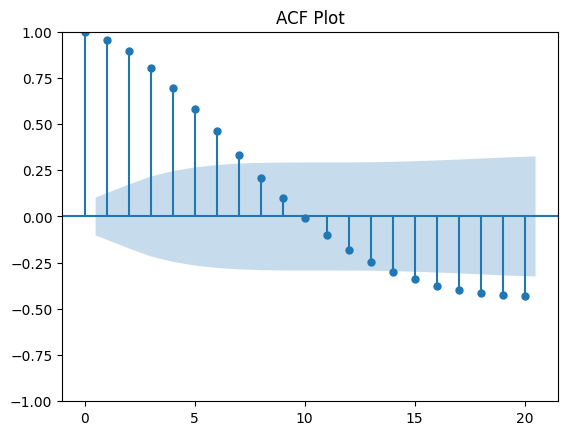

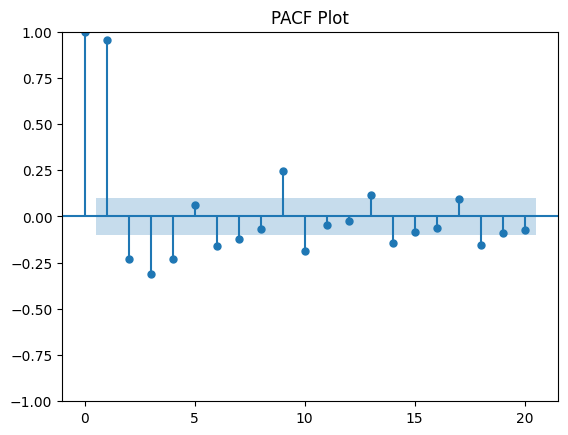

In [14]:
# Generate ACF and PACF plots
plot_acf(smoothed_series, lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(smoothed_series, lags=20)
plt.title("PACF Plot")
plt.show()

In [ ]:
best_order, best_aic = find_best_arima_order(smoothed_series)
print(f"Best model order: {best_order} with AIC: {best_aic}")

In [16]:
# Build an ARIMA(1, 0, 1) model for the time series
model = ARIMA(smoothed_series, order=(2, 0, 2))
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  365
Model:                       ARIMA(2, 0, 2)   Log Likelihood               -3663.262
Date:                      Thu, 12 Dec 2024   AIC                           7338.525
Time:                              12:00:02   BIC                           7361.924
Sample:                          01-07-2018   HQIC                          7347.824
                               - 12-29-2024                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.427e+04   4380.929      3.258      0.001    5685.683    2.29e+04
ar.L1          1.8296      0.049     37.060      0.000       1.733       1.926
ar.L

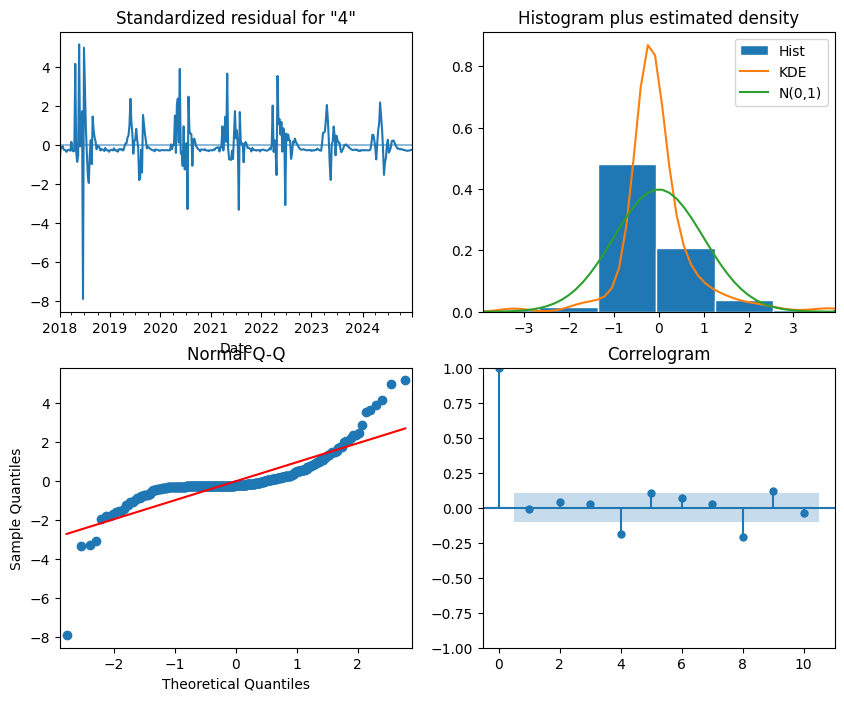

In [17]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

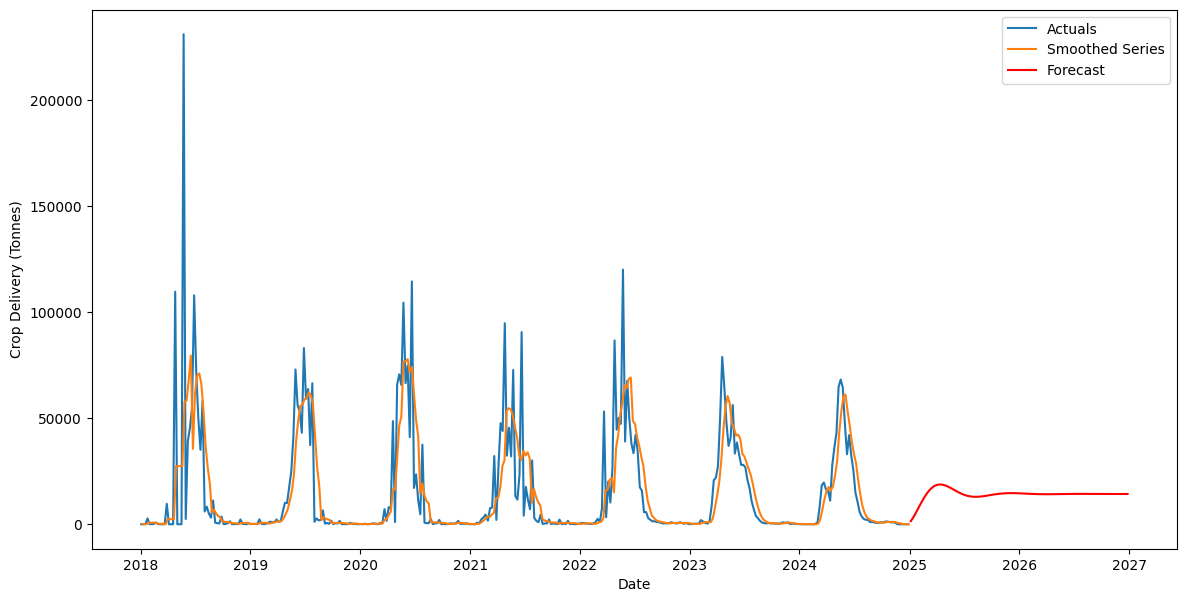

In [18]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

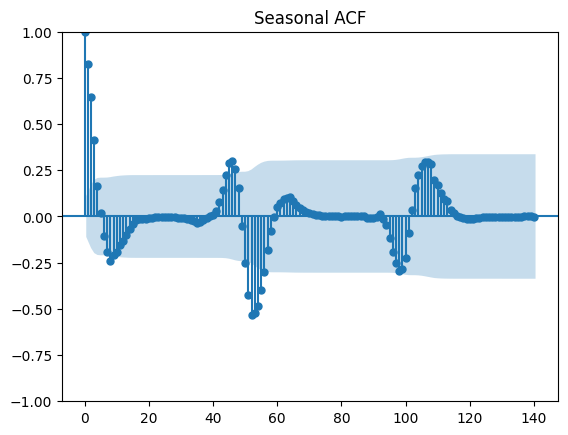

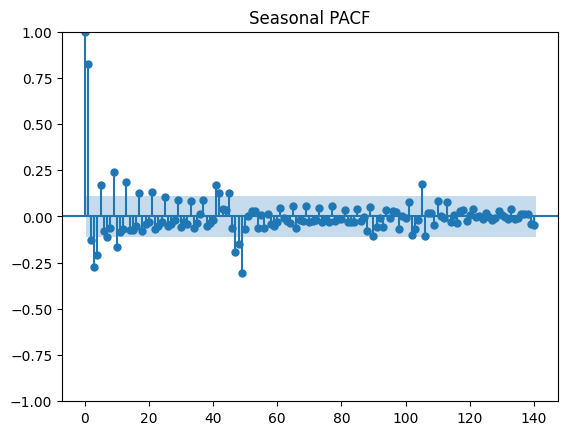

In [19]:
# Seasonal differencing (if necessary)
seasonal_diff = smoothed_series.diff(PERIOD).dropna()

# ACF and PACF for seasonally differenced data
plot_acf(seasonal_diff, lags=140)
plt.title("Seasonal ACF")
plt.show()

plot_pacf(seasonal_diff, lags=140)
plt.title("Seasonal PACF")
plt.show()

In [20]:
# best_order, best_seasonal_order = find_best_sarima_model(
#     resampled_df[TARGET_VARIABLE], PERIOD
# )
# print(f"Best order: {best_order}")
# print(f"Best seasonal order: {best_seasonal_order}")

In [ ]:
# Build a seasonal ARIMA model for the time series
model = SARIMAX(
    smoothed_series,
    order=MODEL_PARMS["order"],
    seasonal_order=MODEL_PARMS["seasonal_order"],
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

In [ ]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [ ]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

In [24]:
# Apply the Holt-Winters seasonal method with additive trend and seasonality to the time series
model = ExponentialSmoothing(
    smoothed_series, trend="add", seasonal="add", seasonal_periods=PERIOD
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                         ExponentialSmoothing Model Results                         
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  365
Model:                 ExponentialSmoothing   SSE                    10199719370.089
Optimized:                             True   AIC                           6370.191
Trend:                             Additive   BIC                           6588.585
Seasonal:                          Additive   AICC                          6392.557
Seasonal Periods:                        52   Date:                 Thu, 12 Dec 2024
Box-Cox:                              False   Time:                         12:00:03
Box-Cox Coeff.:                        None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8889286                alpha           

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


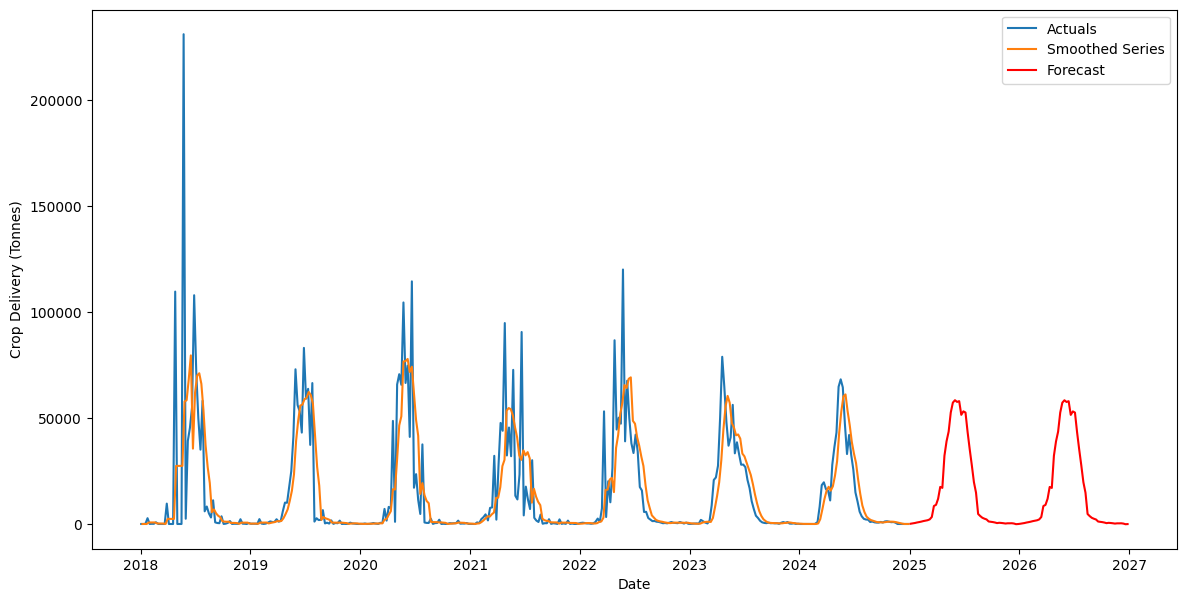

In [25]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)
forecast.rename("predicted_mean", inplace=True)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

12:00:03 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing


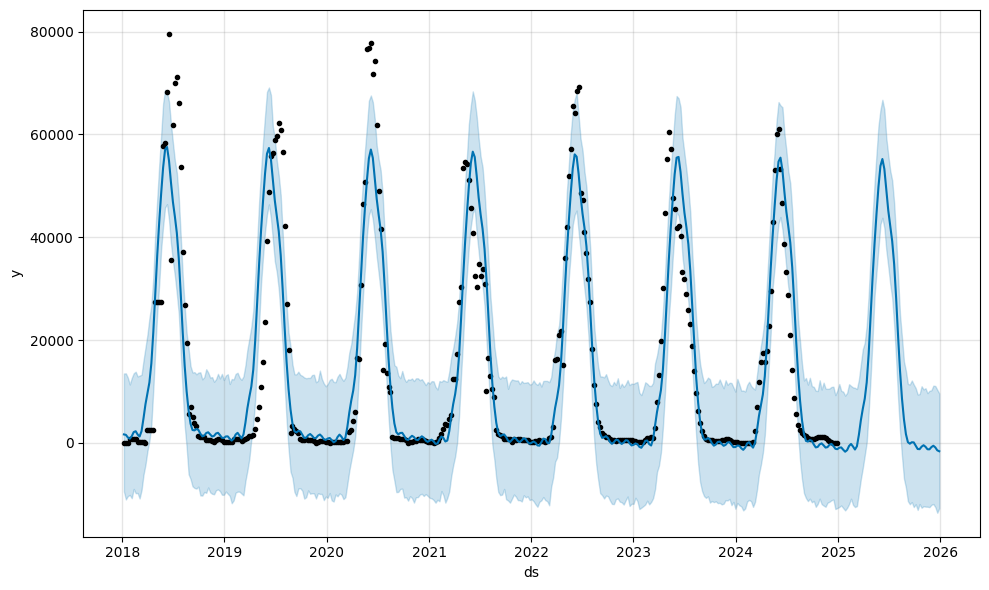

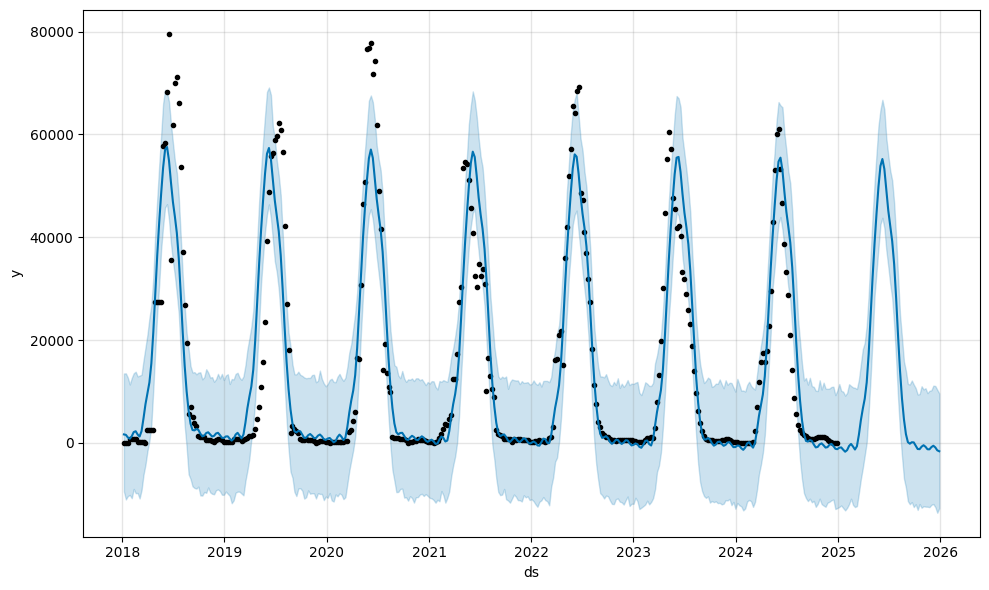

In [26]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = smoothed_series.reset_index().rename(
    columns={"Date": "ds", SMOOTHED_TARGET_VARIABLE: "y"}
)
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

Train Split 1: 2018-01-07 to 2019-03-31 (65 samples)
Train Split 2: 2018-01-07 to 2020-05-24 (125 samples)
Train Split 3: 2018-01-07 to 2021-07-18 (185 samples)
Train Split 4: 2018-01-07 to 2022-09-11 (245 samples)
Train Split 5: 2018-01-07 to 2023-11-05 (305 samples)


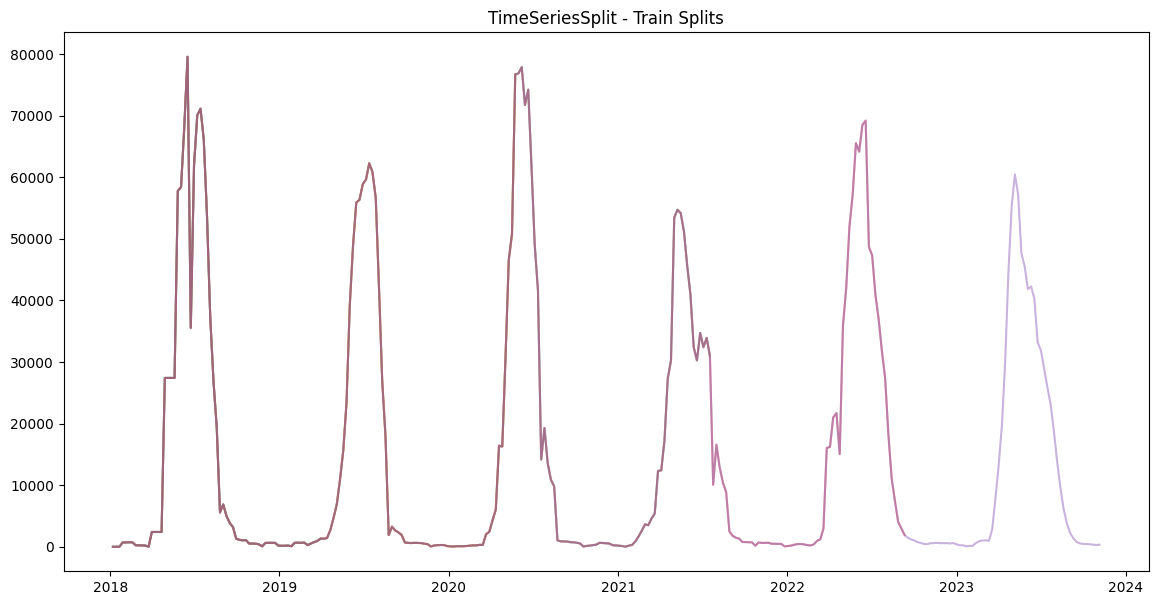

In [27]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit()
plot_train_splits(tscv, smoothed_series)

Test Split 1: 2019-04-07 to 2020-05-24 (60 samples)
Test Split 2: 2020-05-31 to 2021-07-18 (60 samples)
Test Split 3: 2021-07-25 to 2022-09-11 (60 samples)
Test Split 4: 2022-09-18 to 2023-11-05 (60 samples)
Test Split 5: 2023-11-12 to 2024-12-29 (60 samples)


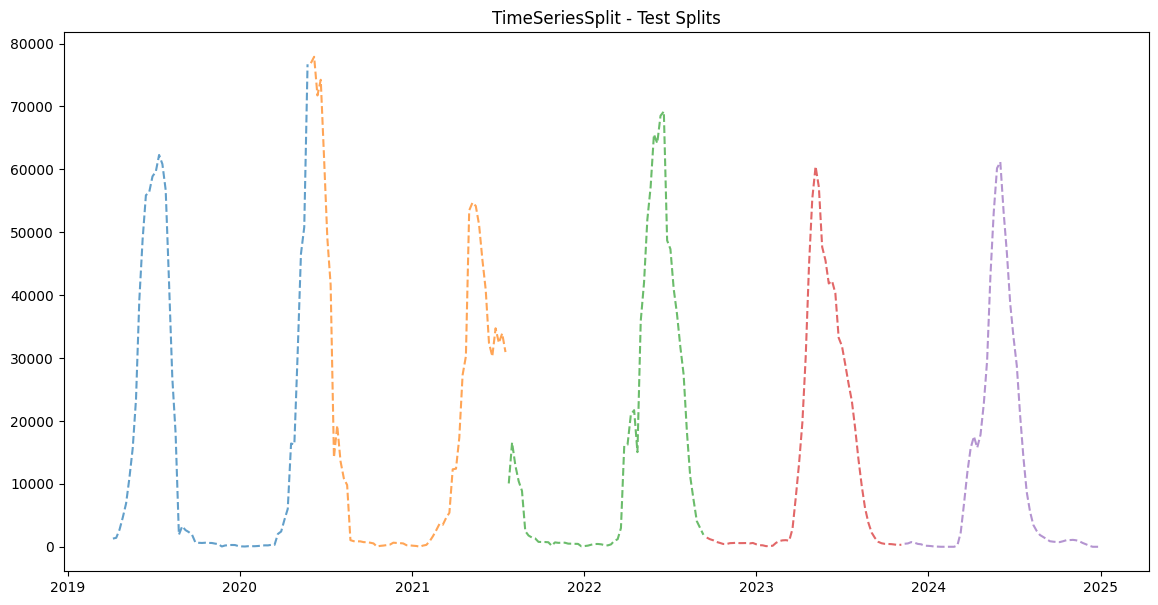

In [28]:
plot_test_splits(tscv, smoothed_series)

In [ ]:
tscv = TimeSeriesSplit(n_splits=2)  # Create 4 splits
results = evaluate_models(smoothed_series, tscv, PERIOD, MODEL_PARMS)
results

In [30]:
# ranked_results_df = rank_models(results)

In [31]:
# Assuming 'train' is your training data and 'test' is your test data
eighty_percent = int(TRAIN_SPLIT * len(smoothed_series))
train = smoothed_series[:eighty_percent]  # Example: first 80% for training
test = smoothed_series[eighty_percent:]  # Remaining 20% for testing

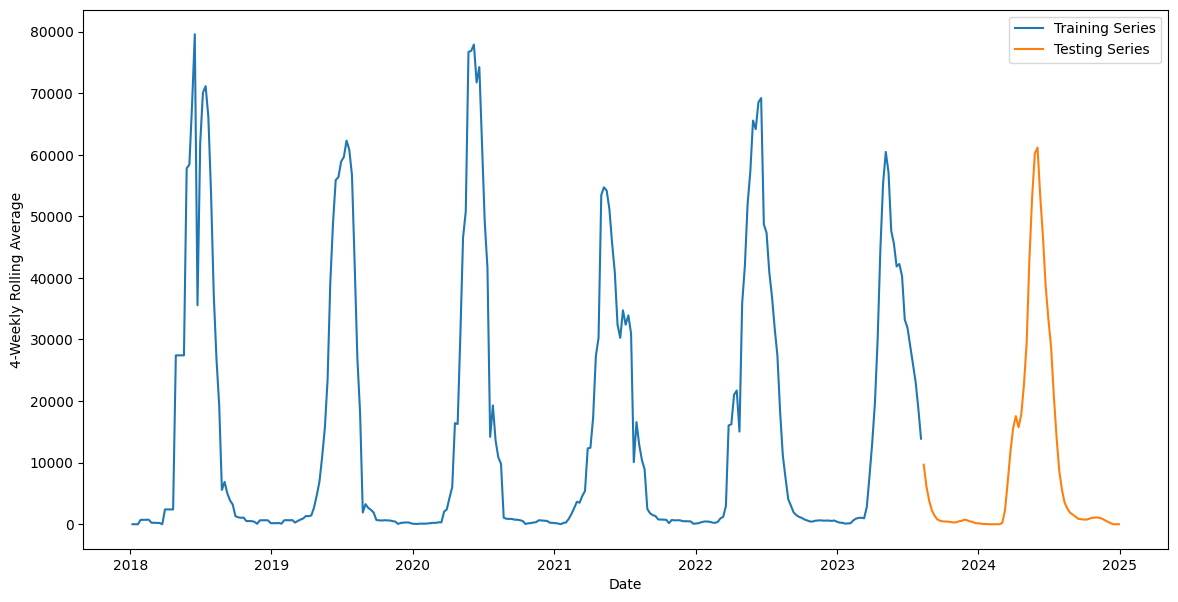

In [32]:
plot_eighty_twenty_series(train, test)

In [ ]:
# Call the function
sarima, sarima_forecast, mae_sarima, rmse_sarima = fit_sarima_model(
    train, test, MODEL_PARMS
)

In [34]:
# Call the function
exp_smooth, exp_smooth_forecast, mae_exp_smooth, rmse_exp_smooth = fit_exp_smooth_model(
    train, test, PERIOD
)

SARIMA - MAE: 6871.335491528527, RMSE: 7425.504107340187, MAPE: inf


c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [36]:
model, prophet_forecast, mae_prophet, rmse_prophet = fit_prophet_model(fb_df, test)

12:00:31 - cmdstanpy - INFO - Chain [1] start processing
12:00:31 - cmdstanpy - INFO - Chain [1] done processing


SARIMA - MAE: 3291.684186727278, RMSE: 5660.41871610697, MAPE: inf


In [ ]:
# Create a dictionary with the metrics
metrics = {
    "Model": ["SARIMA", "Exponential Smoothing", "Prophet"],
    "MAE": [mae_sarima, mae_exp_smooth, mae_prophet],
    "RMSE": [rmse_sarima, rmse_exp_smooth, rmse_prophet],
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Call the function
display_metrics(metrics_df)

,Model,MAE,RMSE,MAE Rank,RMSE Rank
0,SARIMA,2588.934131,4755.988727,1.0,1.0
2,Prophet,3291.684187,5660.418716,2.0,2.0
1,Exponential Smoothing,6871.335492,7425.504107,3.0,3.0


<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

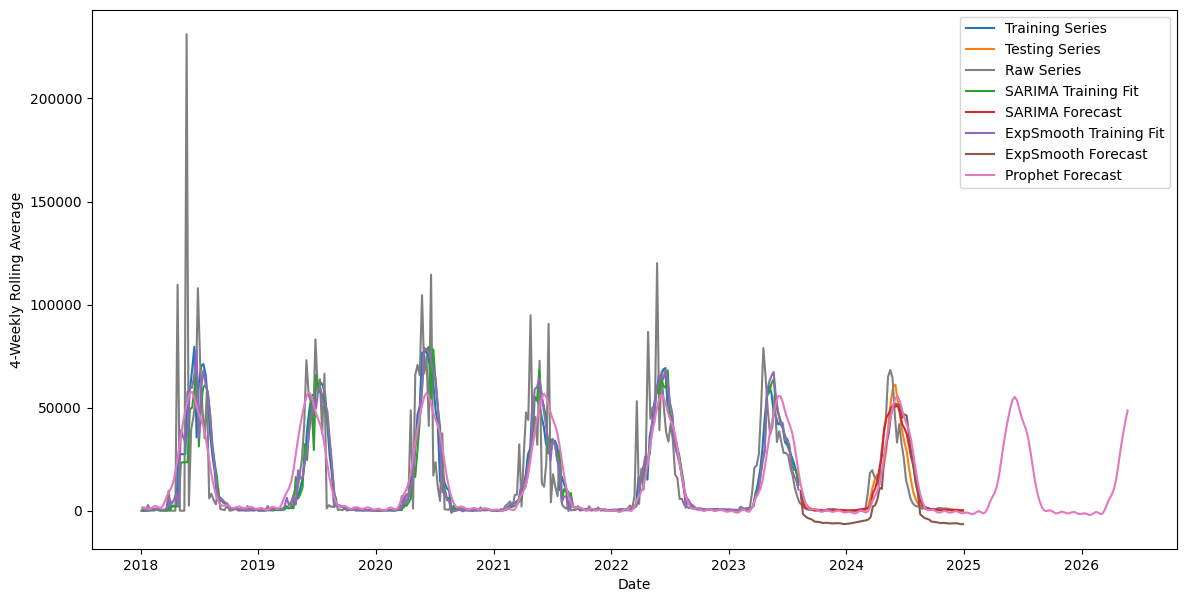

In [ ]:
plt.figure(figsize=(14, 7))

# Plot the training series
sns.lineplot(x=train.index, y=train, label="Training Series")

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=cleaned_df.index,
    y=cleaned_df[TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=train.index, y=sarima.fittedvalues, label="SARIMA Training Fit")
sns.lineplot(x=test.index, y=sarima_forecast, label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(x=train.index, y=exp_smooth.fittedvalues, label="ExpSmooth Training Fit")
sns.lineplot(x=test.index, y=exp_smooth_forecast, label="ExpSmooth Forecast")

# Plot Prophet model output
sns.lineplot(
    x=prophet_forecast.index,
    y=prophet_forecast.to_frame()["yhat"],
    label="Prophet Forecast",
)

<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

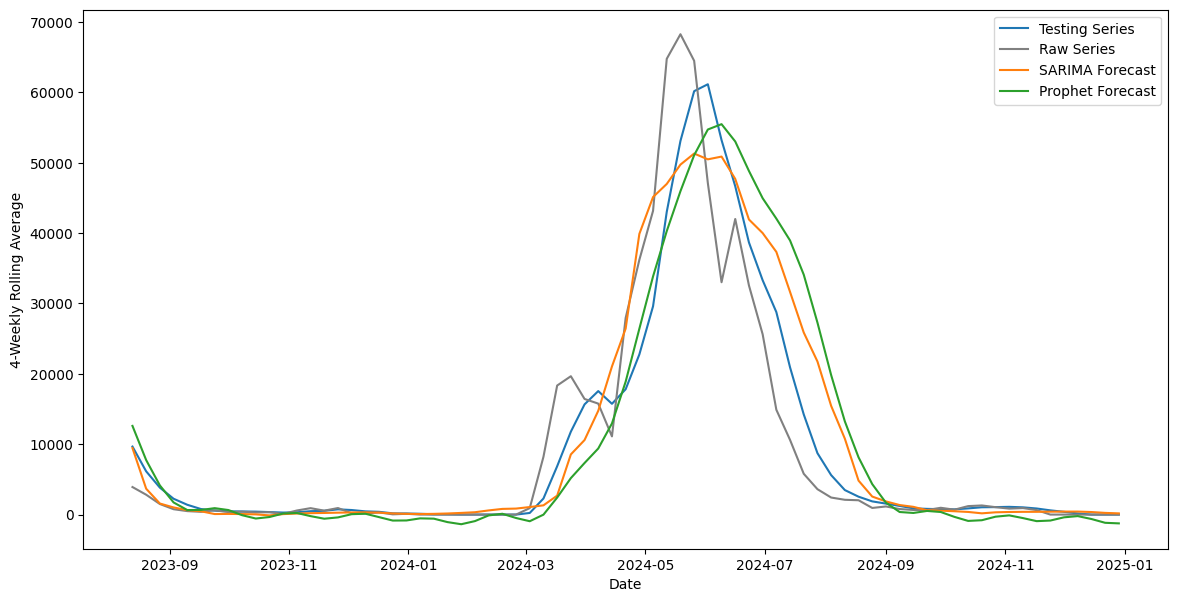

In [ ]:
plt.figure(figsize=(14, 7))

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=resampled_df.loc[test.index].index,
    y=resampled_df.loc[test.index, TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=test.index, y=sarima_forecast.loc[test.index], label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(
    x=test.index, y=exp_smooth_forecast.loc[test.index], label="ExpSmooth Forecast"
)

# Plot Prophet model output
sns.lineplot(x=test.index, y=prophet_forecast.loc[test.index], label="Prophet Forecast")

In [ ]:
save_model(sarima, MODEL_PATH, MODEL_FILE)